# Multi-armed bandit
### Thompson sampling with success probability constraint and stochastic rewards

In [1]:
from matplotlib import pyplot as plt

import numpy as np
import ray
import time

from source import determine_bler_at_sinr
from source import Environment, OracleConstrainedBandit, ThompsonSamplingBandit, OuterLoopLinkAdaptation

plt.rcParams.update({'font.size': 22, 'lines.linewidth' : 3})

ray_redis_address = "130.237.50.33:15672"
ray.init(redis_address=ray_redis_address, ignore_reinit_error=True, log_to_driver=False)

{'node_ip_address': '130.237.50.33',
 'redis_address': '130.237.50.33:15672',
 'object_store_address': '/tmp/ray/session_2020-01-31_14-33-24_593303_6242/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-01-31_14-33-24_593303_6242/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2020-01-31_14-33-24_593303_6242'}

In [2]:
@ray.remote
def f():
    time.sleep(0.01)
    return ray.services.get_node_ip_address()

# Get a list of the IP addresses of the nodes that have joined the cluster.
ray_node_ips = set(ray.get([f.remote() for _ in range(1000)]))
print('Number of active Ray nodes: %d'%(len(ray_node_ips)))

Number of active Ray nodes: 1


# Load Offline Model

16


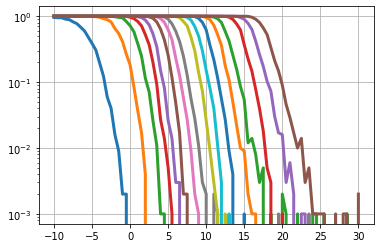

In [3]:
awgn_datafile = 'AWGN_CUSTOM_CONFIG_DATAFILE.npy'
awgn_data = np.load( awgn_datafile, encoding='latin1', allow_pickle=True )[ ( ) ]

snr_vs_bler = np.array(awgn_data['snr_vs_bler'])
snr_range_dB = np.array(awgn_data['snr_range_dB'])

ignore_mcs = [0, 9, 15, 19, 20, 21]

snr_vs_bler = np.delete(snr_vs_bler, ignore_mcs, 1)

nrof_snr, nrof_mcs = snr_vs_bler.shape

print(nrof_mcs)

plt.figure()
plt.grid(True)
for i in range(nrof_mcs):
    plt.semilogy(snr_range_dB, snr_vs_bler[:, i])
    
plt.show()

In [4]:
snr_index = 32
snr_level = snr_range_dB[snr_index]
print('SNR level: %0.2f dB'%(snr_level))

nrof_arms = nrof_mcs
success_prob = 1.0 - snr_vs_bler[snr_index, :]

reward_value = [ 20, 20, 40, 64, 84, 104, 124, 148, 168, 148, 188, 232, 272, 316, 356, 400, 408, 472, 536, 900, 660, 724 ]
reward_value = [r for i, r in enumerate(reward_value) if i not in ignore_mcs]

target_success_prob = 0.85

SNR level: 6.00 dB


In [5]:
print(success_prob)

cqi = max(np.argwhere(success_prob >= 0.9))[0]
print('CQI: %d'%(cqi))

[1.    1.    1.    1.    0.997 0.952 0.77  0.409 0.012 0.    0.    0.
 0.    0.    0.    0.   ]
CQI: 5


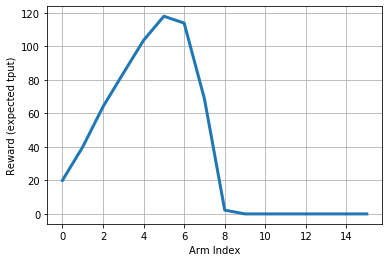

In [6]:
expected_reward = [suc_prob * rew for suc_prob, rew in zip(success_prob, reward_value)]

plt.figure()
plt.grid(True)
plt.plot(expected_reward)

plt.xlabel('Arm Index')
plt.ylabel('Reward (expected tput)')
plt.show()

In [7]:
@ray.remote # Comment out this line to run locally
def run_experiment(policy, T, play_result, reward_value):
    outcome = np.zeros((T, 2))
    for t in range(T):    
        arm = policy.act()
        success = play_result[t][arm]

        outcome[t, 0] = success
        
        if success:
            outcome[t, 1] = reward_value[arm]
        
        policy.update(arm, success)
        
    return outcome

In [8]:
def play(policy, T, N, play_result, reward_value, name):
    start = time.time()
    
    # Uncomment the following line to run locally
    #outcome = [run_experiment(policy, T, play_result[n], reward_value) for n in range(N)]
    outcome = ray.get([run_experiment.remote(policy, T, play_result[n], reward_value) for n in range(N)])
        
    total_success = np.zeros((T))
    total_reward = np.zeros((T))
    for n in range(N):
        total_success += outcome[n][:, 0]
        total_reward += outcome[n][:, 1]
    
    print(name + ' done! Elasped: %0.2fs'%(time.time() - start))
    
    return (total_success / N, total_reward / N)

In [9]:
T = 100
N = 48

# Generate all events in advance
np.random.seed(42)
env = Environment(success_prob)

play_result = [[[env.pull(arm, t) for arm in range(nrof_arms)] for t in range(T)] for _ in range(N)]

oracle_avg_success, oracle_avg_reward = play( OracleConstrainedBandit(nrof_arms,
                                                                      reward_value,  
                                                                      target_success_prob,
                                                                      env_instance=env), 
                                              T, 
                                              N, 
                                              play_result, 
                                              reward_value, 
                                              'Oracle' )

con_ts_avg_success, con_ts_avg_reward = play( ThompsonSamplingBandit(nrof_arms,
                                                                     reward_value,
                                                                     target_success_prob), 
                                        T, 
                                        N, 
                                        play_result, 
                                        reward_value,
                                        'Con-TS' )

# Informed Priors
cqi = max(np.argwhere(success_prob >= 0.9))[0]
estimated_sinr = estimate_sinr_from_cqi(cqi)
bler = determine_bler_at_sinr(estimated_sinr)
prior = [(1.0 - b) for b in bler]
    
con_ts_infp_avg_success, con_ts_infp_avg_reward = play( ThompsonSamplingBandit(nrof_arms,
                                                                               reward_value,
                                                                               target_success_prob,
                                                                               prior_success_mean=prior), 
                                              T, 
                                              N, 
                                              play_result, 
                                              reward_value,
                                              'Con-TS-Infp' )

# Outer Loop Link Adaptation
olla_avg_success, olla_avg_reward = play( OuterLoopLinkAdaptation( nrof_arms, 
                                                                   reward_value,
                                                                   target_success_prob,
                                                                   cqi=cqi), 
                                                      T, 
                                                      N, 
                                                      play_result, 
                                                      reward_value,
                                                      'OLLA' )


RayTaskError: [36mray_worker:__main__.run_experiment()[39m (pid=8108, host=gpu1)
  File "<ipython-input-7-50f7f06bfbcc>", line 5, in run_experiment
  File "/home/vidits/workspace/rate-selection-per-constraint/source.py", line 260, in act
    self.env = env_instance
  File "/home/vidits/workspace/rate-selection-per-constraint/source.py", line 204, in calculate_selection_probabilities
    # Calculate the selection probability vector by solving a linear program
NameError: name 'matrix' is not defined


In [20]:
data = {'oracle_avg_success': oracle_avg_success,
        'oracle_avg_reward': oracle_avg_reward,
        'con_ts_avg_success': con_ts_avg_success,
        'con_ts_avg_reward': con_ts_avg_reward,
        'con_ts_infp_avg_success': con_ts_infp_avg_success,
        'con_ts_infp_avg_reward': con_ts_infp_avg_reward,
        'olla_avg_success': olla_avg_success,
        'olla_avg_reward': olla_avg_reward,
        'target_success_prob': target_success_prob,
 #       'success_prob': success_prob,
        'T': T,
        'N': N}

#filename = 'RESULTS/RESULTS_OLLA_%ddB.npy'%(int(snr_level))
#np.save(filename, data)

# Non-stationary Environment

In [16]:
T = 1000
N = 100

success_prob_1 = 1.0 - snr_vs_bler[32, :]  # 6 dB
success_prob_2 = 1.0 - snr_vs_bler[38, :]  # 9 dB
success_prob_3 = 1.0 - snr_vs_bler[44, :]  # 12 dB

# Generate all events in advance
np.random.seed(42)
env = Environment([success_prob_1, success_prob_2, success_prob_3], True, 250)

play_result = [[[env.pull(arm, t) for arm in range(nrof_arms)] for t in range(T)] for _ in range(N)]

solvers.options['show_progress'] = False

oracle_avg_success, oracle_avg_reward = play( OracleConstrainedBandit(nrof_arms,
                                                                      reward_value,  
                                                                      target_success_prob,
                                                                      env_instance=env), 
                                              T, 
                                              N, 
                                              play_result, 
                                              reward_value, 
                                              'Oracle' )

con_ts_avg_success, con_ts_avg_reward = play( ThompsonSamplingBandit(nrof_arms,
                                                                     reward_value,
                                                                     target_success_prob,
                                                                     window_size=100), 
                                        T, 
                                        N, 
                                        play_result, 
                                        reward_value,
                                        'Con-TS' )

# Informed Priors
cqi = max(np.argwhere(success_prob >= 0.9))[0]
estimated_sinr = estimate_sinr_from_cqi(cqi)
bler = determine_bler_at_sinr(estimated_sinr)
prior = [(1.0 - b) for b in bler]
    
con_ts_infp_avg_success, con_ts_infp_avg_reward = play( ThompsonSamplingBandit(nrof_arms,
                                                                               reward_value,
                                                                               target_success_prob,
                                                                               window_size=100,
                                                                               prior_success_mean=prior), 
                                                      T, 
                                                      N, 
                                                      play_result, 
                                                      reward_value,
                                                      'Con-TS-Infp' )

# Outer Loop Link Adaptation
olla_avg_success, olla_avg_reward = play( OuterLoopLinkAdaptation( nrof_arms, 
                                                                   reward_value,
                                                                   target_success_prob,
                                                                   window_size=100,
                                                                   cqi=cqi), 
                                                                  T, 
                                                                  N, 
                                                                  play_result, 
                                                                  reward_value,
                                                                  'OLLA' )



Oracle done! Elasped: 368.83s
Con-TS done! Elasped: 354.47s
Con-TS-Infp done! Elasped: 352.17s
OLLA done! Elasped: 331.47s


In [17]:
data = {'oracle_avg_success': oracle_avg_success,
        'oracle_avg_reward': oracle_avg_reward,
        'con_ts_avg_success': con_ts_avg_success,
        'con_ts_avg_reward': con_ts_avg_reward,
        'con_ts_infp_avg_success': con_ts_infp_avg_success,
        'con_ts_infp_avg_reward': con_ts_infp_avg_reward,
        'olla_avg_success': olla_avg_success,
        'olla_avg_reward': olla_avg_reward,
        'target_success_prob': target_success_prob,
 #       'success_prob': success_prob,
        'T': T,
        'N': N}

filename = 'RESULTS/RESULTS_OLLA_NONSTATIONARY.npy'
np.save(filename, data)

# Load and plot stuff

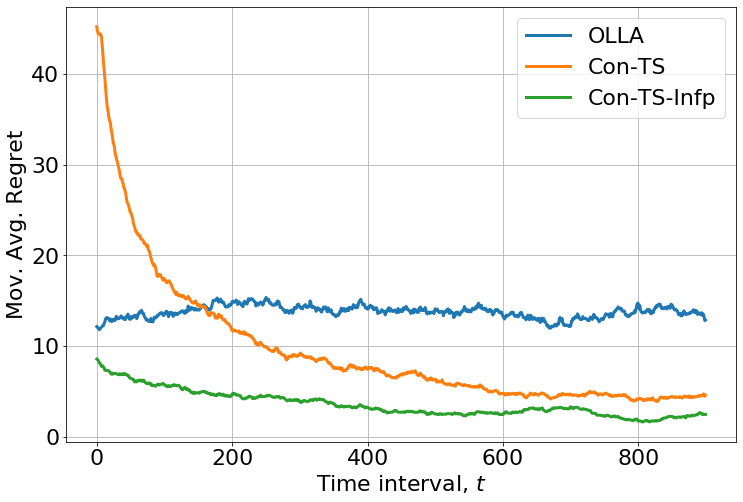

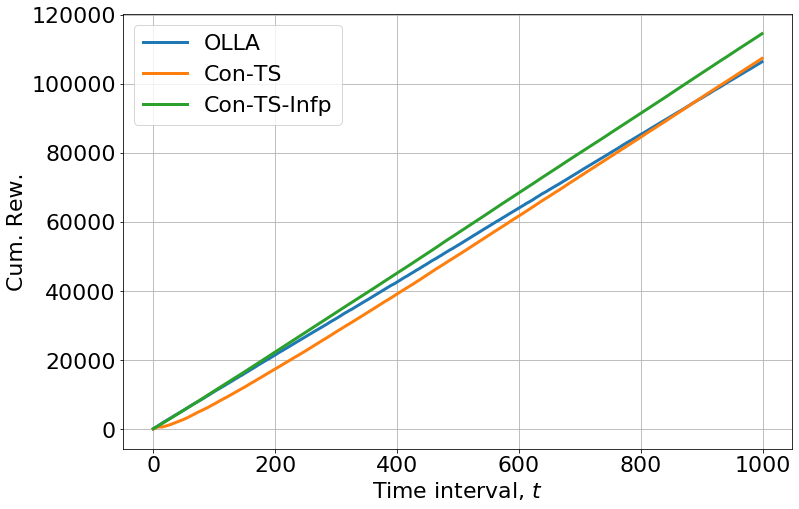

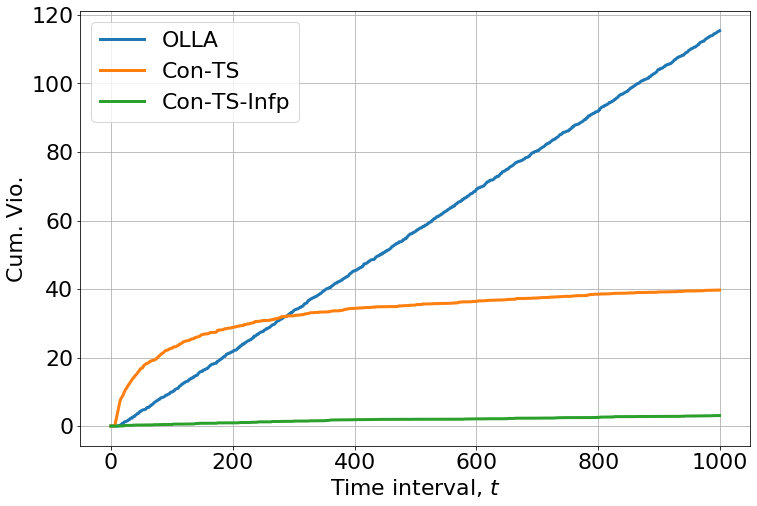

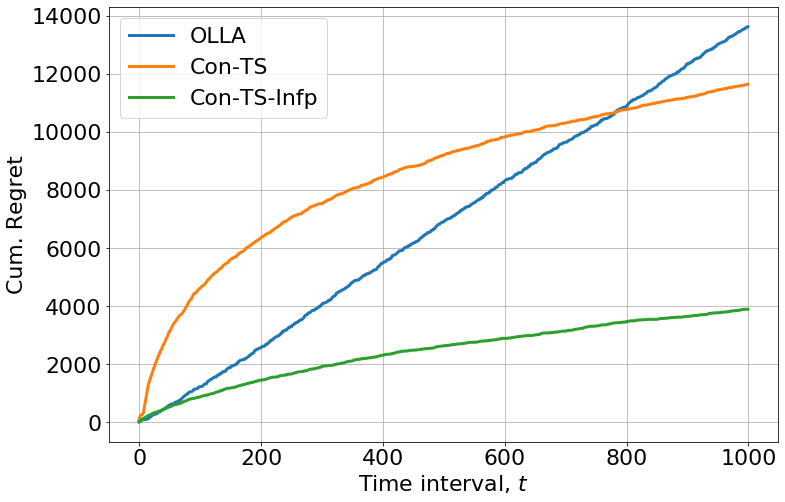

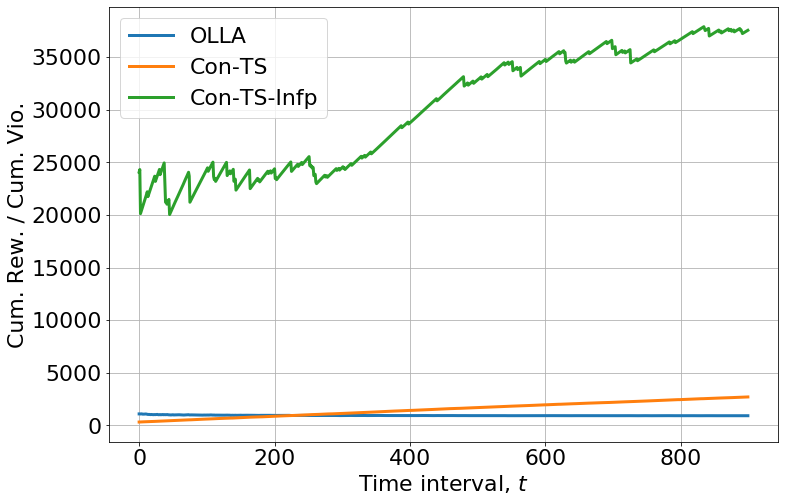

In [21]:
plt.rcParams.update({'font.size': 22, 'lines.linewidth' : 3})

olla_cum_reward = np.cumsum(data['olla_avg_reward'])
con_ts_cum_reward= np.cumsum(data['con_ts_avg_reward'])
con_ts_infp_cum_reward = np.cumsum(data['con_ts_infp_avg_reward'])
oracle_cum_reward = np.cumsum(data['oracle_avg_reward'])

def movavg(cumsum, win_size=100):
    return (cumsum[win_size:] - cumsum[:-1 * win_size]) / win_size
                             
olla_cum_vio = np.cumsum(np.maximum(0.0, target_success_prob - data['olla_avg_success']))
con_ts_cum_vio = np.cumsum(np.maximum(0.0, target_success_prob - data['con_ts_avg_success']))
con_ts_infp_cum_vio = np.cumsum(np.maximum(0.0, target_success_prob - data['con_ts_infp_avg_success']))

olla_cum_regret = np.cumsum(np.maximum(0.0, data['oracle_avg_reward'] - data['olla_avg_reward']))
con_ts_cum_regret= np.cumsum(np.maximum(0.0, data['oracle_avg_reward'] - data['con_ts_avg_reward']))
con_ts_infp_cum_regret = np.cumsum(np.maximum(0.0, data['oracle_avg_reward'] - data['con_ts_infp_avg_reward']))

# Mov. Avg. Regret
plt.figure(figsize=[12, 8])
plt.grid(True)

plt.plot(movavg(olla_cum_regret))
plt.plot(movavg(con_ts_cum_regret))
plt.plot(movavg(con_ts_infp_cum_regret))

plt.legend(['OLLA', 'Con-TS', 'Con-TS-Infp'])
plt.xlabel('Time interval, $t$')
plt.ylabel('Mov. Avg. Regret')

plt.show()

# Cum. Rew.
plt.figure(figsize=[12, 8])
plt.grid(True)

plt.plot(olla_cum_reward)
plt.plot(con_ts_cum_reward)
plt.plot(con_ts_infp_cum_reward)

plt.legend(['OLLA', 'Con-TS', 'Con-TS-Infp'])
plt.xlabel('Time interval, $t$')
plt.ylabel('Cum. Rew.')

plt.show()

# Cum. Vio.
plt.figure(figsize=[12, 8])
plt.grid(True)

plt.plot(olla_cum_vio)
plt.plot(con_ts_cum_vio)
plt.plot(con_ts_infp_cum_vio)

plt.legend(['OLLA', 'Con-TS', 'Con-TS-Infp'])
plt.xlabel('Time interval, $t$')
plt.ylabel('Cum. Vio.')

plt.show()

# Cum. Regret
plt.figure(figsize=[12, 8])
plt.grid(True)

plt.plot(olla_cum_regret)
plt.plot(con_ts_cum_regret)
plt.plot(con_ts_infp_cum_regret)

plt.legend(['OLLA', 'Con-TS', 'Con-TS-Infp'])
plt.xlabel('Time interval, $t$')
plt.ylabel('Cum. Regret')

plt.show()

# Cum. Rew. / Cum. Vio.
plt.figure(figsize=[12, 8])
plt.grid(True)

offset = 100
plt.plot(np.divide(olla_cum_reward[offset:], olla_cum_vio[offset:]))
plt.plot(np.divide(con_ts_cum_reward[offset:], con_ts_cum_vio[offset:]))
plt.plot(np.divide(con_ts_infp_cum_reward[offset:], con_ts_infp_cum_vio[offset:]))

plt.legend(['OLLA', 'Con-TS', 'Con-TS-Infp'])
plt.xlabel('Time interval, $t$')
plt.ylabel('Cum. Rew. / Cum. Vio.')

plt.show()

Text(0, 0.5, 'Average Reward Events  $E[x_{k(t)}]$')

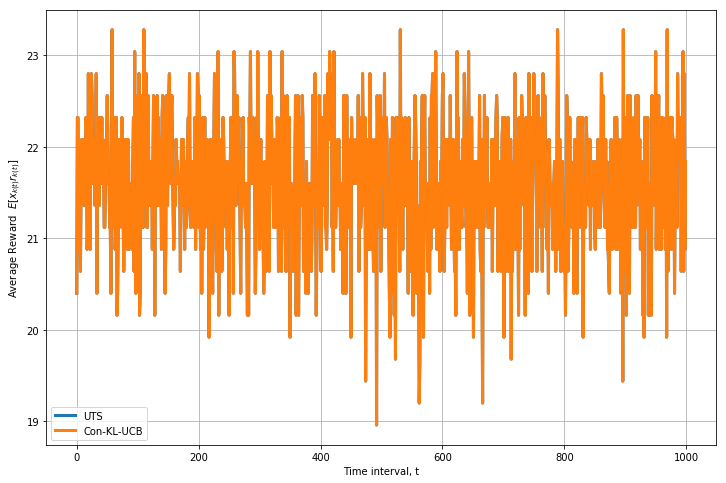

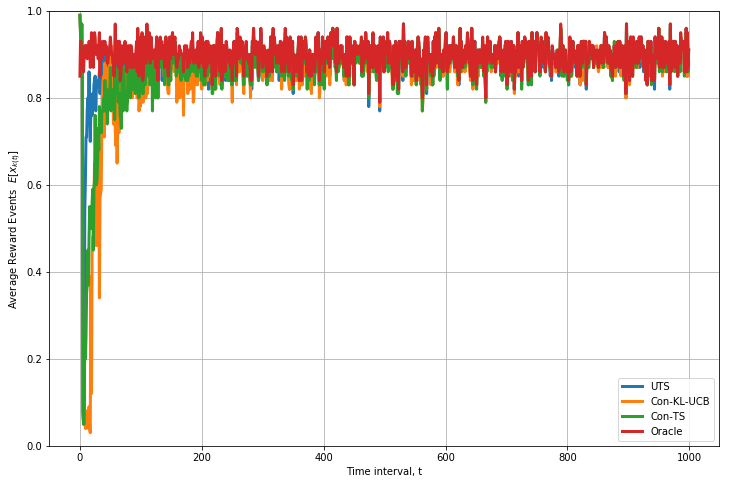

In [51]:
plt.figure(figsize=[12, 8])
plt.grid(True)

#plt.plot(data['uts_avg_reward'])
#plt.plot(data['con_kl_ucb_avg_reward'])
#plt.plot(data['con_ts_avg_reward'])
plt.plot(oracle1_avg_reward)
plt.plot(data['oracle_avg_reward'])

plt.legend(['UTS', 'Con-KL-UCB', 'Con-TS', 'Oracle'])

#plt.ylim([0.0, 1])
plt.xlabel('Time interval, t')
plt.ylabel('Average Reward  $E[x_{k(t)}r_{k(t)}]$')


plt.figure(figsize=[12, 8])
plt.grid(True)

plt.plot(data['uts_avg_success'])
plt.plot(data['con_kl_ucb_avg_success'])
plt.plot(data['con_ts_avg_success'])
plt.plot(data['oracle_avg_success'])

plt.legend(['UTS', 'Con-KL-UCB', 'Con-TS', 'Oracle'])

plt.ylim([0, 1])
plt.xlabel('Time interval, t')
plt.ylabel('Average Reward Events  $E[x_{k(t)}]$')